## 1.导入包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
"""
网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合
网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况
下面要做的事情：
1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动
2.考虑正则化或者假如droput层来防止过拟合
3.考虑数据预处理中采用数据标准化，让数据均匀分布
4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）
5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例
6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量
"""

'\n网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合\n网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况\n下面要做的事情：\n1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动\n2.考虑正则化或者假如droput层来防止过拟合\n3.考虑数据预处理中采用数据标准化，让数据均匀分布\n4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）\n5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例\n6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量\n'

## 2.加载数据

"""
1.功能：
通过加载data和label文件，然后继续训练和预测。
定义了一个6层卷积神经网络模型。每个卷积层后面跟着一个 ReLU 激活函数。第七层只有卷积，没有relu。
输入数据n*64*64*2,这里的一个样本64*64可以看成一个图片格式（在此次任务中是速度，两者类似）
输出是n*64*64*4
"""
"""txt保存为numpy格式发现可以减少存储大小，约缩小成1/4
5.9G	./all_data.npy
12G	./all_label.npy
27G	./data_64x64x2.txt
53G	./label_a_2x64x65x2.txt
"""

In [3]:
# 直接加载npy文件为numpy格式
all_data = np.load('./data/all_data.npy')
# #直接加载npy文件为numpy格式,注意标签是面心值，不是a值
all_label = np.load('./data/all_centerFace_label.npy')

all_data = torch.tensor(all_data).float()
all_label = torch.tensor(all_label).float()


## 3.构建模型

In [4]:

#神经网络模型
class Net(nn.Module):
    def __init__(self, num_output_channels):
        super(Net, self).__init__()

        # 第一层卷积，使用64个大小为3x3的卷积核，输入数据的shape为2x64x64，使用ReLU激活函数。
        # 输入通道数为2，输出通道数恒为64
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        # 第二层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # 第三层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # 第四层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # 第五层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()

        # 第六层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()

        # 第七层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数,输出数据为4*64*64
        # 输入通道数为64，输出通道数恒为4
        self.conv7 = nn.Conv2d(64, num_output_channels, kernel_size=3, stride=1, padding=1)



    def forward(self, x):
        x = self.conv1(x)  # x:torch.Size([10, 2, 64, 64])
        x = self.relu1(x)

        x = self.conv2(x)  # x:torch.Size([10, 64, 64, 64])
        x = self.relu2(x)

        x = self.conv3(x)  # x:  torch.Size([10, 64, 64, 64])
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.relu6(x)

        x = self.conv7(x)

        # 输出数据shape: torch.Size([10, 4, 64, 64]),10是batch_size大小
        return x



In [5]:
"""
早停法是一种被广泛使用的方法，在很多案例上都比正则化的方法要好。
其基本含义是在训练中计算模型在验证集上的表现，
当模型在验证集上的表现开始下降的时候，停止训练，这样就能避免继续训练导致过拟合的问题。
"""

'\n早停法是一种被广泛使用的方法，在很多案例上都比正则化的方法要好。\n其基本含义是在训练中计算模型在验证集上的表现，\n当模型在验证集上的表现开始下降的时候，停止训练，这样就能避免继续训练导致过拟合的问题。\n'

## 4.模型训练与测试

In [6]:
import time
from sklearn.model_selection import train_test_split

def train(num_output_channels):
    start_time = time.time()

    # 定义一个batch包含的样本数目
    batch_size = 128

    # 生成数据集
    x_train, x_test, y_train, y_test = train_test_split(all_data, all_label, test_size=0.2)

    # 设置种子数
    seed = 42
    torch.manual_seed(seed)

    # 划分数据集
    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # 划分数据集
    testset = torch.utils.data.TensorDataset(x_test, y_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    # 创建模型实例，并将模型移动到GPU设备上进行计算
    net = Net(num_output_channels).to(device)
    
    # 加速训练：如果有多个GPU，则使用DataParallel模块
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
        print("采用DataParallel加速，device_count个数为：", str(torch.cuda.device_count()))
        
    # 定义损失函数为均方误差
    criterion = nn.MSELoss()
    
    # 定义优化器为Adam优化器，设置学习率为0.001
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    print('begin to train!!!')

    # 训练模型
    num_epochs = 1000  # 训练轮数
    
    train_loss = []
    test_loss = []
    best_loss = float('inf')  # 初始化最佳验证集损失值为正无穷大
    patience = 10  # 设置连续多少次验证集损失值不下降时停止训练
    count = 0  # 记录连续不下降次数
    
    for epoch in range(num_epochs):
        
        #训练
        running_train_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            
        train_loss.append(running_train_loss)
        
        # 测试
        running_test_loss = 0.0
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            
        test_loss.append(running_test_loss)
        print("已完成第：", str(epoch+1), "个epoch! Train Loss:", running_train_loss, "Test Loss:", running_test_loss)

        # 早停法
        """
        如果<连续多个 epoch> 的<验证集损失值>都没有<下降>，即验证集损失值不再降低，那么就会认为模型已经过拟合或者无法继续改善。
        这时，训练会提前停止，并保存当前的模型参数
        """
        if running_test_loss < best_loss:

            best_loss = running_test_loss
            count = 0 #连续十次测试集的epoch loss不下降，故只要又一次下降，就清零重新计算
        else:
            count += 1
            if count >= patience:
                print(f"验证集损失值连续{patience}次不下降，停止训练！")
                break
                
        if epoch==500:
            torch.save(net, './model/model_origin_500_01.pth')


    end_time = time.time()
    process_time = end_time - start_time
    print(f"模型训练和测试共用了: {process_time} 秒！")
    print('all of tasks Finished')
    
    # 保存整个模型
    torch.save(net, './model/model_origin_1000_zaoting_01.pth')
    
    return train_loss, test_loss

train_loss, test_loss = train(num_output_channels=4)
print(train_loss)
print(test_loss)
np.save('./data/lossa/loss_model_1000_zaoting_01.npy', np.array([train_loss, test_loss]))


采用DataParallel加速，device_count个数为： 4
begin to train!!!
已完成第： 1 个epoch! Train Loss: 2541.290480732918 Test Loss: 608.2272615432739
已完成第： 2 个epoch! Train Loss: 2408.613397359848 Test Loss: 599.212989449501
已完成第： 3 个epoch! Train Loss: 2383.4660432338715 Test Loss: 593.0071930885315
已完成第： 4 个epoch! Train Loss: 2362.0647975206375 Test Loss: 588.403186917305
已完成第： 5 个epoch! Train Loss: 2343.607312321663 Test Loss: 583.828453540802
已完成第： 6 个epoch! Train Loss: 2326.667551636696 Test Loss: 579.4807844161987
已完成第： 7 个epoch! Train Loss: 2308.933439016342 Test Loss: 575.5854941606522
已完成第： 8 个epoch! Train Loss: 2293.8903220891953 Test Loss: 573.7517565488815
已完成第： 9 个epoch! Train Loss: 2278.4021631479263 Test Loss: 566.8957773447037
已完成第： 10 个epoch! Train Loss: 2263.3985109329224 Test Loss: 565.9829757213593
已完成第： 11 个epoch! Train Loss: 2250.676602602005 Test Loss: 562.1751619577408
已完成第： 12 个epoch! Train Loss: 2239.39561355114 Test Loss: 564.8368278741837
已完成第： 13 个epoch! Train Loss: 2229.46598041

In [7]:
print(all_data.shape)
print(all_label.shape)


torch.Size([192000, 2, 64, 64])
torch.Size([192000, 4, 64, 64])


In [8]:
train_loss,test_loss = np.load('./data/lossa/loss_model_1000_zaoting_01.npy')
print(train_loss)

[2541.29048073 2408.61339736 2383.46604323 2362.06479752 2343.60731232
 2326.66755164 2308.93343902 2293.89032209 2278.40216315 2263.39851093
 2250.6766026  2239.39561355 2229.46598041 2217.97232723 2208.38248169
 2202.18361819 2194.01408648 2187.45693004 2181.21962643 2173.14318514
 2168.94000185 2162.15165305 2158.47126853 2152.50375652 2147.72547126
 2142.43457305 2141.1498009  2135.2996825  2130.70953703 2128.01973438
 2124.41301107 2121.86686087 2117.88007295 2115.10492468 2111.96275699
 2108.20836329 2106.22612894 2102.83920419 2101.62268114 2100.12465203
 2096.07208633 2093.82772529 2092.44810903 2090.74809849 2087.31494546
 2087.30034482 2084.61400843 2081.84069121 2079.83405328 2078.71320152
 2077.88431334 2074.72570872 2074.84796011 2072.38079369 2070.97343302
 2068.95029926 2066.74693382 2066.365008   2064.68254519 2063.92738676
 2062.50911295 2061.04042137 2058.41305721 2058.95758581 2056.17073154
 2056.44340098 2053.85968876 2053.10340512 2052.05788398 2050.84488726
 2049.

# 5.可视化loss

[0.01654, 0.01568, 0.01551, 0.01538, 0.01525, 0.01514, 0.01503, 0.01493, 0.01483, 0.01473, 0.01465, 0.01458, 0.01451, 0.01443, 0.01438, 0.01434, 0.01428, 0.01424, 0.0142, 0.01415, 0.01411, 0.01408, 0.01405, 0.01401, 0.01398, 0.01395, 0.01394, 0.0139, 0.01387, 0.01385, 0.01383, 0.01381, 0.01378, 0.01377, 0.01374, 0.01372, 0.01371, 0.01368, 0.01368, 0.01367, 0.01365, 0.01363, 0.01362, 0.01361, 0.01359, 0.01359, 0.01357, 0.01355, 0.01354, 0.01353, 0.01352, 0.0135, 0.0135, 0.01349, 0.01348, 0.01346, 0.01345, 0.01345, 0.01344, 0.01343, 0.01342, 0.01342, 0.0134, 0.0134, 0.01339, 0.01339, 0.01337, 0.01337, 0.01336, 0.01335, 0.01334, 0.01333, 0.01333, 0.01332, 0.01332, 0.01331, 0.01329, 0.0133, 0.01329, 0.01327, 0.01328, 0.01327, 0.01326, 0.01326, 0.01325, 0.01324, 0.01324, 0.01323, 0.01322, 0.01322, 0.01321, 0.0132, 0.01321, 0.0132]


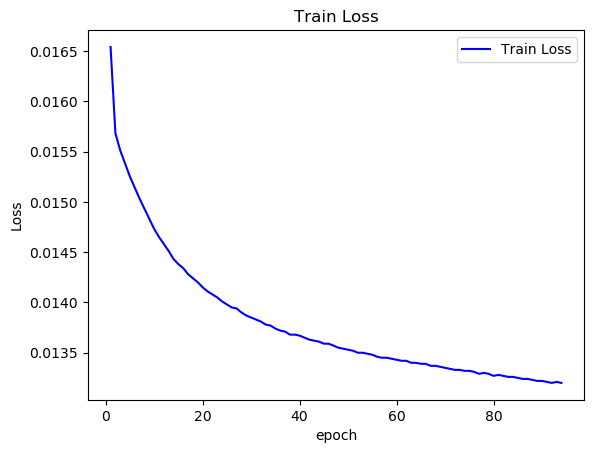

In [9]:
import matplotlib.pyplot as plt
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(train_loss) + 1)

train_loss = [round(int(a)/(all_data.shape[0]*0.8), 5) for a in train_loss]
print(train_loss)
# 绘制训练损失曲线
plt.plot(epoch, train_loss, 'b', label='Train Loss')

# 关闭科学计数法
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# 设置y轴范围下限为0
# plt.ylim(bottom=0)

# 设置图表标题和轴标签
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

[608.22726154 599.21298945 593.00719309 588.40318692 583.82845354
 579.48078442 575.58549416 573.75175655 566.89577734 565.98297572
 562.17516196 564.83682787 559.1487813  553.45627975 551.26221704
 554.29873443 547.618891   549.00659621 547.08951712 542.9183346
 541.7067014  544.16272509 539.81394815 539.9141134  537.55521572
 536.76007128 540.54881799 535.16510785 532.36236835 533.79996467
 532.18112814 530.94547808 532.96434188 528.48308384 529.35788929
 527.77870476 528.36341071 527.98617983 527.6207763  527.58362305
 527.13351738 524.50659025 522.94331825 522.44480944 526.18843257
 527.67807817 524.03780079 522.66378176 521.65175009 522.35212481
 524.13524044 523.12904716 520.45042837 522.81391275 521.86122966
 518.58763444 523.03465593 518.83813083 520.99192619 519.42086899
 522.06725371 517.35883617 522.12969029 515.99030173 516.87183785
 517.25934303 516.95912337 515.61287665 515.27192748 514.60320699
 515.77657306 513.19923699 516.03540552 512.63246608 514.52754545
 512.642903

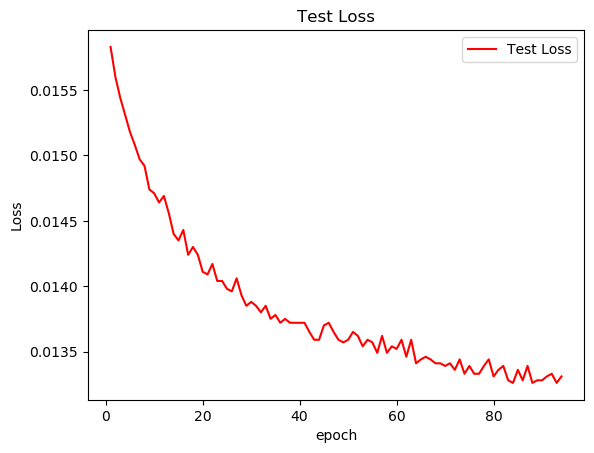

In [10]:
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(test_loss) + 1)
print(test_loss)
test_loss = [round(int(a)/(all_data.shape[0]*0.2), 5) for a in test_loss]


# 绘制测试损失曲线
plt.plot(epoch, test_loss, 'r', label='Test Loss')

# 设置图表标题和轴标签
plt.title('Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [11]:
# from torchsummary import summary
# # 将模型移动到适当的设备
# model = model.to(device)

# # 打印模型的概要信息
# summary(model,input_size=(2, 64, 64))

## 6.预测

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载模型
model = torch.load('./model/model_origin_1000_zaoting_01.pth', map_location=device)# from torchsummary import summary
# # 将模型移动到适当的设备

model = model.to(device)


In [13]:
# 设置模型为评估模式
model.eval()

# 输入数据进行预测
input_data =all_data[-10]  # 你的输入数据


#调整输入input的维度顺序,作为E，用于下面change_Label_to_a中(E-A)/(B-A)得到a值
matrix_64 = input_data.cpu()
matrix_64 = matrix_64.permute(1,2,0)  
print(matrix_64.shape)


# 转换为四维
input_data = input_data.unsqueeze(0)#用实际数据，数据格式为(1,2, 64, 64)，不能为2x64x64
# input_data = torch.randn(1,2, 64, 64)
print(input_data.shape)
input_tensor = input_data.to(device)

with torch.no_grad():
    output = model(input_tensor)##如果报错的话需要把网络的设计加上，里面涉及model(input)

# 打印预测结果
print(output)

torch.Size([64, 64, 2])
torch.Size([1, 2, 64, 64])
tensor([[[[2.3857e+00, 2.6780e+00, 2.8931e+00,  ..., 2.7420e+00,
           2.9825e+00, 2.6640e+00],
          [2.9223e+00, 3.0006e+00, 3.1189e+00,  ..., 2.9669e+00,
           2.9903e+00, 2.9417e+00],
          [3.0739e+00, 3.1605e+00, 3.2666e+00,  ..., 3.1921e+00,
           3.1099e+00, 2.9769e+00],
          ...,
          [3.7269e+00, 3.6663e+00, 3.6262e+00,  ..., 2.6012e+00,
           2.7398e+00, 3.1179e+00],
          [3.3121e+00, 3.1996e+00, 3.1347e+00,  ..., 2.7418e+00,
           2.9170e+00, 2.9608e+00],
          [2.5682e+00, 2.7186e+00, 2.7313e+00,  ..., 2.7210e+00,
           2.7442e+00, 2.4832e+00]],

         [[1.0131e+00, 9.5695e-01, 7.5687e-01,  ..., 1.4775e+00,
           1.3256e+00, 1.0552e+00],
          [1.0862e+00, 8.8842e-01, 7.8266e-01,  ..., 1.3378e+00,
           1.3548e+00, 1.2794e+00],
          [1.1909e+00, 9.4152e-01, 6.9681e-01,  ..., 1.5398e+00,
           1.2716e+00, 1.1357e+00],
          ...,
        

# 8.转换格式(label转为最终的weights)

In [14]:
#将label面心值转为a值
def change_Label_to_a(all_vertical_edge_centers,all_horizontal_edge_centers):
    a_vertical = np.zeros((64, 65, 2))
    # a_vertical = np.random((64, 65, 2))
    a_horizontal = np.zeros((64, 65, 2))
    # a_horizontal = np.random.random((64, 65, 2))


    # 21. 求a:   横着的边，分两种情况，边缘（对称的）和非边缘的边.这里matrix_64要行列互换，因为横着时面心值是一列一列求得，竖着时是一行一行求的。
    for i in range(64):
        for j in range(65):
            if j == 0 or j == 64:
                # a_horizontal[i, j] = (all_horizontal_edge_centers[i, 0] - matrix_64[i, 0]) / (matrix_64[i, 63] - matrix_64[i, 0])#换之前
                a_horizontal[i, j] = (all_horizontal_edge_centers[i, 0] - matrix_64[0, i]) / (
                    matrix_64[63, i] - matrix_64[0, i])
            else:
                # aA=(1-a)B=E   a = (E-B)/(A-B) 其中：A为matrix_64[i,j]，B为matrix_64[i,j+1]
                # a_horizontal[i, j] = (all_horizontal_edge_centers[i, j] - matrix_64[i, j]) / (matrix_64[i, j-1] - matrix_64[i, j])
                a_horizontal[i, j] = (all_horizontal_edge_centers[i, j] - matrix_64[j, i]) / (
                    matrix_64[j - 1, i] - matrix_64[j, i])

    # 22. 求a:   竖着的边，分两种情况，边缘（对称的）和非边缘的边
    for i in range(64):
        for j in range(65):
            if j == 0 or j == 64:
                a_vertical[i, j] = (all_vertical_edge_centers[i, 0] - matrix_64[i, 0]) / (
                    matrix_64[i, 63] - matrix_64[i, 0])
            else:
                # aA=(1-a)B=E   a = (E-B)/(A-B) 其中：A为matrix_64[i,j]，B为matrix_64[i,j+1]
                # 2.错误matrix_64[i, j-1]) / (改成matrix_64[i, j]) / (
                a_vertical[i, j] = (all_vertical_edge_centers[i, j] - matrix_64[i, j]) / (
                    matrix_64[i, j - 1] - matrix_64[i, j])

    # # 若最终a对应的矩阵里面出现无穷，则将其替换为0.5.解决了分母为0的问题
    # a_vertical[np.isinf(a_vertical)] = 0.5
    # a_horizontal[np.isinf(a_horizontal)] = 0.5
    #这里64x65x2截成64x64x2,因为边框对称时值相同
    
    a_vertical = torch.tensor(a_vertical[:,:64,:])
    a_horizontal = torch.tensor(a_horizontal[:,:64,:])

    print(a_vertical.shape)
    print(a_horizontal.shape)
    return  a_vertical,a_horizontal

In [15]:
#返回一个列表，里面嵌套两个子列表，第一个子列表存放的是内部的a值，第二个子列表存放的是边框的a值，
#且顺序为上（左到右），下（左到右），左（下到上），右（下到上）
def conversion_format(output):
    # 调整output的维度顺序
    output = output.permute(0,2,3,1)  
    print(output.shape)
    output = output[0]
    print(output.shape)
    # print(output)

    #将输出output拆成两个面心值
    all_vertical_edge_centers = output[:, :, 0:2].cpu()
    all_horizontal_edge_centers = output[:, :, 2:4].cpu()
    print(all_vertical_edge_centers.shape)
    print(all_horizontal_edge_centers.shape)

    
    a_vertical,a_horizontal  = change_Label_to_a(all_vertical_edge_centers,all_horizontal_edge_centers)    
    
    # 将前两个元素相加除以二得到一个元素(x+y/)2
    avg_vertical = (a_vertical[:, :, 0] + a_vertical[:, :, 1]) / 2
    # 将后两个元素相加除以二得到另一个元素
    avg_horizontal = (a_horizontal[:, :, 0] + a_horizontal[:, :, 1]) / 2

    # 重新组合成新的形状为(64, 64, 2)的张量
    new_avg_a_output = torch.stack([avg_vertical, avg_horizontal], dim=2)
    # 打印转换后的数据形状
    print(new_avg_a_output.shape)

    #返回两个求完平均的面心值,包括两个64*64矩阵，矩阵是求完平均后的a值，一个竖着的，一个横着的
    vertical_1d = new_avg_a_output[:, :, 0]
    horizontal_1d = new_avg_a_output[:, :,1]
    print(vertical_1d.shape)
    print(horizontal_1d.shape)
    
    
    border = []#存所有边框，四个边框
    left_border=[]#存左边框
    bottom_border = []#存下边框
    inner = []#存内部的面心值

    #下面将2个64x64面心值变换格式，返回指定的格式result
    for i in range(len(vertical_1d)): #两个for循环等价于for i in range(64):
        for j in range(len(vertical_1d[i])):
            if j ==0:#j=0添加边框
                #添加左边框
                left_border.append(vertical_1d[i][0])
                #添加下边框
                bottom_border.append(horizontal_1d[i][0])
            else: 
                if i !=  63:#当竖着的最后一行时，上面没有对应的横着的
                    inner.append(vertical_1d[i][j])#竖着的
    #                 print("{j-1},{i+1}",j-1,i+1)
                    inner.append(horizontal_1d[j-1][i+1])   #再横着的   
                    if j == 63:#如果j=63的话，还需要再加入最后一列的横着的边
                        inner.append(horizontal_1d[63][i+1])#当i=63,横着的加最后一列 
                else:#if i ==63 :
                    inner.append(vertical_1d[63][j])#当i=63,inner最后添加竖着的一行竖线

    inner = [tensor.cpu().numpy().tolist() for tensor in inner]#将一维列表里面的tensor元素转为numpy格式，并返回cpu版本
    # print(inner)
    four_border = [bottom_border,bottom_border,left_border,left_border]#顺序是上（左到右），下（左到右），左（下到上），右（下到上）
    border = [item.numpy().tolist() for sublist in four_border for item in sublist]
    result = [inner,border]
    print(len(result))
    return result



In [16]:
result  = conversion_format(output)

torch.Size([1, 64, 64, 4])
torch.Size([64, 64, 4])
torch.Size([64, 64, 2])
torch.Size([64, 64, 2])
torch.Size([64, 64, 2])
torch.Size([64, 64, 2])
torch.Size([64, 64, 2])
torch.Size([64, 64])
torch.Size([64, 64])
2


In [17]:
print(len(result[0]))
print(len(result[1]))
print(8064+64*2)

8064
256
8192


In [20]:
print(result)

[[2.4836694598197937, -8.597235888242722, 0.3264498710632324, -8.015363194048405, -0.5732396841049194, -1.8596742153167725, -1.3778509497642517, -2.6574160754680634, -0.07915091514587402, -2.1621165238320827, -0.4614975340664387, -1.2922511100769043, 0.308148464653641, -1.1547729969024658, 0.4229116626083851, 5.529422789812088, 0.5125684291124344, 5.246886253356934, 0.529563844203949, 3.9684388637542725, 0.4809640794992447, 3.7018544673919678, 0.4257689416408539, 3.562677890062332, 0.3623845800757408, 6.705867230892181, 0.5487320721149445, -20.718132972717285, -3.716041684150696, -1.74059596657753, 0.9171990156173706, -6.050430774688721, -0.13981348276138306, -6.474392294883728, -0.5755628496408463, -1.9291980266571045, -1.1498135924339294, 4.604956731200218, -2.263695329427719, 16.56810173392296, -4.1126114428043365, 11.520779967308044, -7.7704285979270935, 7.781087636947632, -38.93772882223129, -34.80287766456604, 14.162764310836792, 12.784581124782562, 6.362486720085144, 2.544394135

In [21]:
count = sum(1 for num in result[0] if 0 < num < 1)
print(count)
print(count/len(result[0]))

1642
0.20362103174603174
